In [608]:
import numpy as np
import pandas as pd
import patsy as pt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import HTML
import copy
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
import graphviz 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso

## 8.3.1 Fitting Classification Trees

In [609]:
carseats_df = pd.read_csv('./data/Carseats.csv')

# Check for missing values
assert carseats_df.isnull().sum().sum() == 0
# Drop unused index
carseats_df = carseats_df.drop('Unnamed: 0', axis=1)


# Create binary variable High 1 if Sales > 8
carseats_df['High'] = (carseats_df['Sales'] > 8).astype(np.float64)

# Create index for training set
np.random.seed(1)
train = np.random.random(len(carseats_df)) > 0.5


carseats_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,1.0
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,1.0
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,1.0
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,0.0
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,0.0


We now use the tree() function to fit a classification tree in order to predict High using all variables but Sales.

In [620]:
# Use all features excpet response features
# No intercept
f = 'High ~ 0 + ' + ' + '.join(carseats_df.columns.drop(['Sales', 'High']))
y, X = pt.dmatrices(f, carseats_df)
y = y.flatten()

# Fit Sklearns tree classifier
clf = tree.DecisionTreeClassifier(max_depth=4).fit(X, y)

# Visualise the tree with GraphViz
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X.design_info.column_names,  
                                class_names=['Low', 'High'],  
                                filled=True, rounded=True)
graph = graphviz.Source(dot_data) 
display(HTML(graph._repr_svg_()))

In [425]:
# Provide key for variables
list(enumerate(X.design_info.column_names))

[(0, 'ShelveLoc[Bad]'),
 (1, 'ShelveLoc[Good]'),
 (2, 'ShelveLoc[Medium]'),
 (3, 'Urban[T.Yes]'),
 (4, 'US[T.Yes]'),
 (5, 'CompPrice'),
 (6, 'Income'),
 (7, 'Advertising'),
 (8, 'Population'),
 (9, 'Price'),
 (10, 'Age'),
 (11, 'Education')]

### list the variables that are used as internal nodes in the tree, the number of terminal nodes, and the (training) error rate.

In [426]:
# Classifier achives perfect score on training set due to overfitting
clf.score(X, y)

array(0.84)

In [427]:
# Here's the confusion matrix
confusion_matrix(y, clf.predict(X))

array([[220,  16],
       [ 48, 116]])

Sklearn doesn't expose the same stats as R's summary such as number of leaves. This is what is available.

In [428]:
help(tree._tree.Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The maximal depth of the tree.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child of node i.
 |      For leaves,

In [429]:
clf.tree_.node_count

29

In [430]:
clf.tree_.max_depth

4

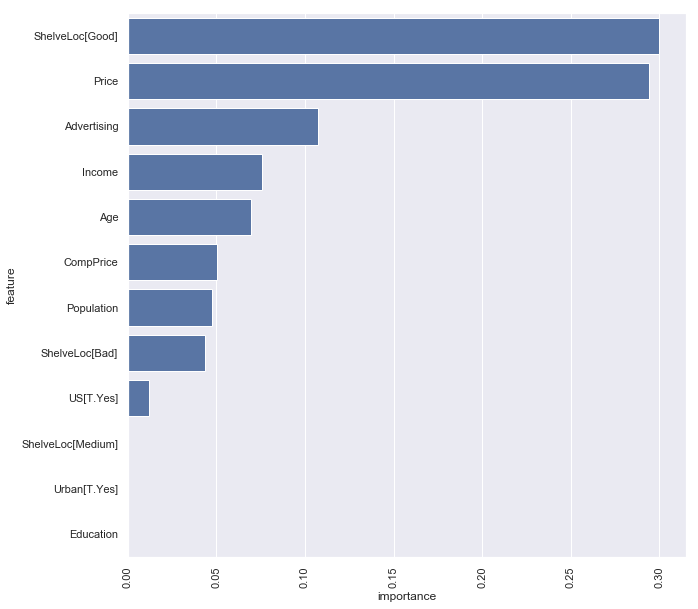

In [431]:
# Plot feature by importance in this model

plot_df = pd.DataFrame({'feature': X.design_info.column_names, 'importance': clf.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

In order to properly evaluate the performance of a classification tree on these data, we must estimate the test error rather than simply computing the training error. We split the observations into a training set and a test set, build the tree using the training set, and evaluate its performance on the test data. The predict() function can be used for this purpose. In the case of a classification tree, the argument type="class" instructs R to return the actual class prediction. This approach leads to correct predictions for around 71.5 % of the locations in the test data set.

In [432]:
# Fit Sklearn's tree classifier
clf = tree.DecisionTreeClassifier(max_depth=5).fit(X[train], y[train])

# Get confusion matrix for test set
y_hat = clf.predict(X[~train])
display(confusion_matrix(y[~train], y_hat))

# Get proportion of correct classifications on test set
print('Test accuracy: {}'.format(np.around(clf.score(X[~train], y[~train]), 4)))



array([[93, 16],
       [35, 40]])

Test accuracy: 0.7228


Note variance in this result if above code snippet is run repeatedly.

### Tree Pruning

Sklearn doesn't support tree pruning at time of writing. 

This is the closest I could find to an implementation:
https://stackoverflow.com/questions/49428469/pruning-decision-trees

But the above is not pruning as described in ISL, because in ISL the tree is fit with a penalty function for the number of terminal nodes in the tree (see eq 8.4 p 309), whereas the above example is pruning based on some threshold for the 'value' variable, the meaning of which is unclear to me.

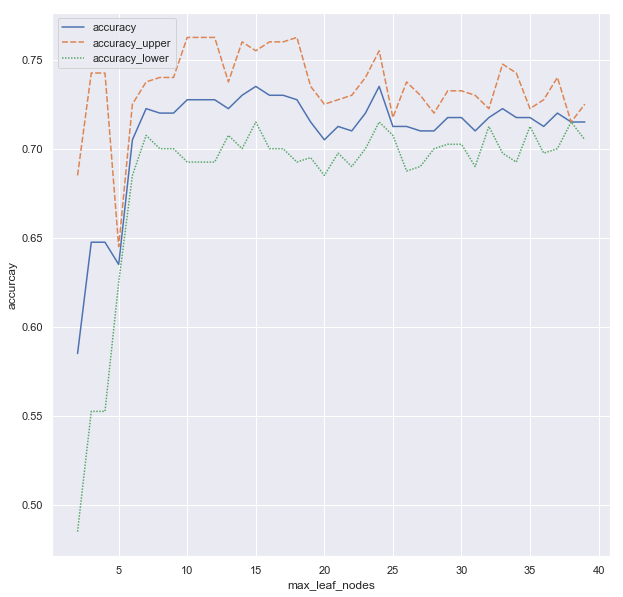

In [621]:
# How about using CV to compare trees with different number of leaf nodes 
# as defined by the max_leaf_nodes parameter?

tuning_param = 'max_leaf_nodes'
columns=[tuning_param, 'accuracy', 'accuracy_upper', 'accuracy_lower']

results = []
for m in np.arange(2, 40):
    clf = tree.DecisionTreeClassifier(max_leaf_nodes=m)
    scores = cross_val_score(clf, X, y, cv=2)
    #rmses = np.sqrt(np.absolute(scores))
    rmse = np.mean(scores)
    conf_int = np.std(scores) *2
    results += [[m, rmse, rmse+conf_int, rmse-conf_int]]


# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.asarray(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(10,10))
sns.lineplot(data=plot_df)
plt.ylabel('accurcay');

Above we plot 2-fold cv test accuracy for increasing number of leave nodes. ~15 leaves appears optimal. The model appears to overfit only slightly as the number of leaves increases.

Note, and alternative approach is to increase max_depth as a more coarse tuning parameter.

## 8.3.2 Fitting Regression Trees

Here we fit a regression tree to the Boston data set. First, we create a training set, and fit the tree to the training data.

In [613]:
boston_df = datasets.load_boston()
boston_df = pd.DataFrame(data=np.c_[boston_df['data'], boston_df['target']], columns= [c for c in boston_df['feature_names']] + ['Price'])

np.random.seed(1)
train = np.random.rand(len(boston_df)) < 0.5

boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [614]:
f = 'Price ~ ' + ' + '.join(boston_df.columns.drop(['Price']))
y, X = pt.dmatrices(f, boston_df)

In [615]:
# Fit Sklearns tree classifier
clf = tree.DecisionTreeRegressor(max_leaf_nodes=5).fit(X[train], y[train])

y_hat = clf.predict(X[~train])
rmse = np.sqrt(metrics.mean_squared_error(y[~train], y_hat))
print('RMSE test: {}'.format(np.around(rmse, 3)))

RMSE test: 5.521


In [616]:
# Visualise the tree with GraphViz
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X.design_info.column_names, 
                                filled=True, rounded=True)
graph = graphviz.Source(dot_data) 
display(HTML(graph._repr_svg_()))

The variable LSTAT measures the percentage of individuals with lower socioeconomic status. The tree indicates that lower values of LSTAT correspond to more expensive houses. The tree predicts a house price of $46,873 for larger homes in suburbs in which residents have high socioeconomic status (LSTAT<9.545 and RM>7.445).

Now we use the cv.tree() function to see whether pruning the tree will improve performance.

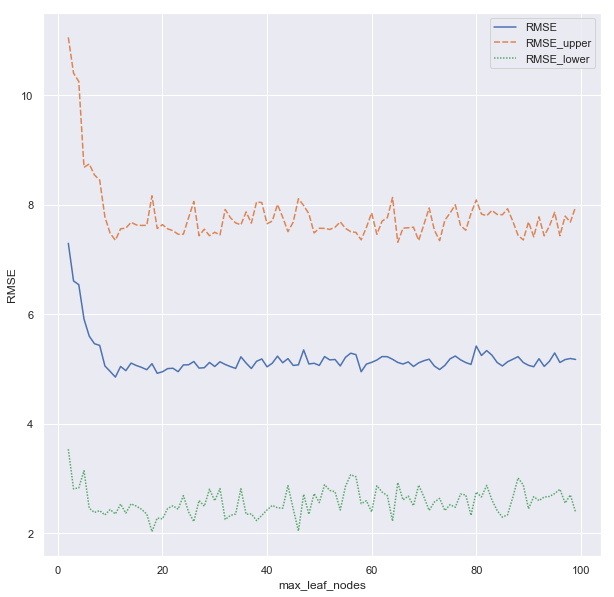

,RMSE,RMSE_upper,RMSE_lower
max_leaf_nodes,,,
11.0,4.85267,7.354009,2.351331


In [463]:
tuning_param = 'max_leaf_nodes'
cv_folds = 5
columns=[tuning_param, 'RMSE', 'RMSE_upper', 'RMSE_lower']

results = []
for m in np.arange(2, 100):
    reg = tree.DecisionTreeRegressor(max_leaf_nodes=m)
    scores = cross_val_score(reg, X[train], y[train], cv=cv_folds, scoring='neg_mean_squared_error')
    rmses = np.sqrt(np.absolute(scores))
    rmse = np.mean(rmses)
    conf_int = np.std(rmses) *2
    results += [[m, rmse, rmse+conf_int, rmse-conf_int]]


# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.asarray(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(10,10))
sns.lineplot(data=plot_df)
plt.ylabel('RMSE')
plt.show();

# Choose model
choice = plot_df[plot_df['RMSE'] == plot_df['RMSE'].min()]
display(choice)

In [468]:
reg = tree.DecisionTreeRegressor(max_leaf_nodes=np.int(choice.index[0])).fit(X[train], y[train])
y_hat = reg.predict(X[~train])

rmse = np.sqrt(metrics.mean_squared_error(y[~train], y_hat))
print('RMSE test: ${}'.format(np.int(rmse*1000)))

RMSE test: $4736


In [475]:
boston_df['Price'].median()*1000

21200.0

A test RMSE of 4.736 is achieved for the selected model, which suggest that this model can predict house prices to within \$4,736 of the true median value of a house ($21200 in this dataset)

## 8.3.3 Bagging and Random Forests

### Bagging

In [530]:
# Bagging with 100 trees
# although I'm using RandomForestRegressor algo here this is Bagging because max_features = n_predictors

max_features = X.shape[1]
tree_count   = 100

regr   = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
regr.fit(X[train], y[train])
y_hat = regr.predict(X[~train])

mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

MSE test: 11.135
RMSE test: 3.337


Bagging seems to yield a significant improvement in RMSE for the test set of $3337 (compared to $4736 for single optimal decision tree).

### Random forest

In [528]:
# Random Forest with 100 trees and 4 features considered at each split

max_features = 4
tree_count   = 100

regr   = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
regr.fit(X[train], y[train])
y_hat = regr.predict(X[~train])

mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

MSE test: 9.201
RMSE test: 3.033


Random forest yields a further improvement over bagging with RMSE of $3,033 with 4 features considered at each split.

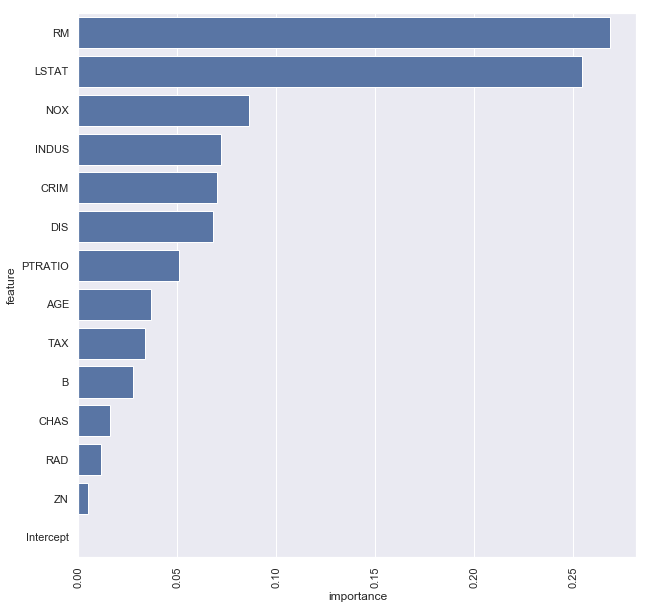

In [529]:
# Plot feature by importance in this model

plot_df = pd.DataFrame({'feature': X.design_info.column_names, 'importance': regr.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

**ISL author:** 
The results indicate that across all of the trees considered in the random forest, the wealth level of the community (lstat) and the house size (rm) are by far the two most important variables.

## 8.3.4 Boosting

In [547]:
# Gradient boosting

max_features = 'auto'
l            = 0.1
tree_count   = 100


regr   = GradientBoostingRegressor(max_features=max_features, 
                                   random_state=1, 
                                   n_estimators=tree_count,
                                   learning_rate=l)
regr.fit(X[train], y[train])
y_hat = regr.predict(X[~train])

mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

MSE test: 10.654
RMSE test: 3.264


In [577]:
# Gradient boosting

max_features  = 4
learning_rate = 0.1
tree_count    = 100


regr   = GradientBoostingRegressor(max_features=max_features, 
                                   random_state=1, 
                                   n_estimators=tree_count,
                                   learning_rate=learning_rate)
regr.fit(X[train], y[train])
y_hat = regr.predict(X[~train])

mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

MSE test: 8.11
RMSE test: 2.848


With max_features set to auto all features are used, I assume we describe this as 'bagging with boosting'. This yields an RMSE of 3.264 a slight improvement over bagging 3.337.

Setting max_features to 4 gives the best RMSE so far at 2.848 which is almost have the error observed for a single tree regression.



## Off-piste

A few experiments not part of ISL lab that I wanted to do out of interest.

### Comparison with Lasso

The lasso was one of the most reliable models introduced in ch6. How does the lasso compare with the results above?

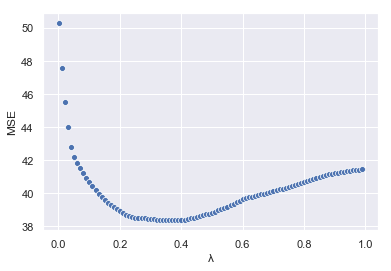

RMSE Train CV: 6.194201937281284
@Lambda: 0.36099999999999993
MSE test: 24.655
RMSE test: 4.965


In [596]:
def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = Lasso(alpha=λ, copy_X=True, fit_intercept=False, max_iter=10000,
                      normalize=True, positive=False, precompute=False, random_state=0,
                      selection='cyclic', tol=0.0001, warm_start=False).fit(X_train, y_train)
        
        # Measure MSE
        y_hat = model.predict(X_test)
        #print(y_test)
        MSEs += [metrics.mean_squared_error(y_test, y_hat)]
    return MSEs

X_train = pd.DataFrame(X[train], columns=X.design_info.column_names)
y_train = pd.DataFrame(y[train], columns=['Price'])

lambdas = np.arange(.001, 1, .01)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X_train, y_train, λ=l, k=5))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}))
plt.show();

# Choose model
lamb = min(zip(MSEs, lambdas))
print('RMSE Train CV: {}\n@Lambda: {}'.format(np.sqrt(lamb[0]), lamb[1]))


# Use chosen model on test set prediction
model = Lasso(alpha=lamb[1], copy_X=True, fit_intercept=False, max_iter=10000,
              normalize=True, positive=False, precompute=False, random_state=0,
              selection='cyclic', tol=0.0001, warm_start=False).fit(X[train], y[train])

y_hat = model.predict(X[~train])

mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

The lasso yields an RMSE of 4.965 which is similar to the optimal single tree found above (4.736). In this setting Bagging, Random Forest and Boosting outperform the lasso with boosting yielding an RMSE of 2.848.

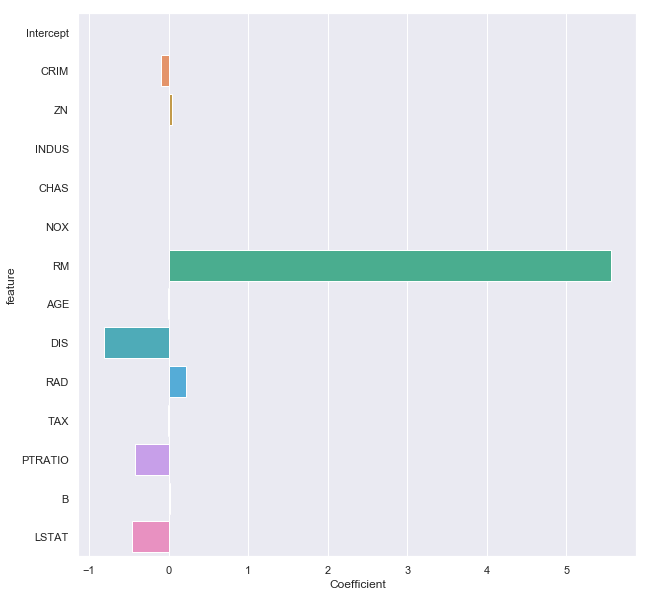

In [606]:
# How does Lasso weight feature importance compared to tree-based methods?
plt.figure(figsize=(10,10))
sns.barplot(x='Coefficient', y='feature', data=pd.DataFrame({'feature': X.design_info.column_names, 'Coefficient': model.coef_}));

We saw that tree-base methods ranked affluence of the community and house size (LSTAT, RM respectively) as the most important features when predicting slae price. 

Similarly the Lasso places a high weight on house size but does not consider LSTAT as strongly.

### Todo: It would be nice to try XgBoost for comparison here too